In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import shutil
from datetime import datetime
from src.data.preload_data import *
from src.utils import read_config, plot_training_metrics
from gridworld.gridworld import GridWorld
from src.constants import *
from src.model import TemporalPCN, HierarchicalPCN
from src.trainer import PCTrainer
from ruamel.yaml import YAML

ModuleNotFoundError: No module named 'numpy'

In [2]:
def create_folder_with_datetime(base_name):
    """
    Создает папку с именем `base_name_YYYY-MM-DD_HH-MM`.
    Если папка уже существует - удаляет её и создает новую.
    Возвращает путь к созданной папке.
    """
    # Формат даты без секунд
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
    folder_name = f"{base_name}_{current_time}"
    
    # Удаляем папку, если она существует
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
    
    # Создаем новую папку
    os.makedirs(folder_name, exist_ok=True)
    print(f"Папка создана: {folder_name}")
    return folder_name

In [3]:
class UniqueColorPicker:
    def __init__(self, palette_name="husl"):
        """
        Инициализация выбора цветов из палитры seaborn.
        
        :param palette_name: Имя палитры (по умолчанию "husl" — хорошая палитра для различимости)
        """
        self.palette_name = palette_name
        self.available_colors = sns.color_palette(palette_name)
        self.used_colors = set()
        
    def get_unique_color(self):
        """
        Возвращает случайный не повторяющийся цвет из палитры.
        Если все цвета использованы, сбрасывает счётчик и начинает заново.
        """
        if not self.available_colors:
            # Если цвета закончились, сбрасываем и начинаем заново
            self.available_colors = sns.color_palette(self.palette_name)
            self.used_colors = set()
        
        # Выбираем случайный цвет из оставшихся
        color = random.choice(self.available_colors)
        
        # Удаляем его из доступных и добавляем в использованные
        self.available_colors.remove(color)
        self.used_colors.add(tuple(color))  # Конвертируем в tuple, т.к. список нехешируемый
        
        return color


In [4]:
def save_yaml(data, path):
    """
    Сохраняет данные в YAML-файл по относительному пути.
    Требует, чтобы целевая папка уже существовала.
    
    Параметры:
        data (dict): Данные для сохранения
        path (str): Относительный путь (с расширением или без)
                   Пример: "configs/exp1" → сохранит в "configs/exp1.yaml"
    """
    yaml = YAML()
    yaml.indent(mapping=2, sequence=4, offset=2)
    yaml.preserve_quotes = True
    yaml.allow_unicode = True


    if not path.endswith(('.yaml', '.yml')):
        path += '.yaml'

    
    with open(path, 'w', encoding='utf-8') as f:
        yaml.dump(data, f)

    print(f"Файл сохранён: {path}")

In [5]:
import random

def random_pair_generator(min_val_1=3, max_val_1=4, min_val_2=0, max_val_2=4):
    """
    Генератор бесконечных случайных пар чисел (кортежей)
    
    Параметры:
        min_val (int): Минимальное значение (включительно)
        max_val (int): Максимальное значение (включительно)
        
    Возвращает:
        tuple: Кортеж вида (x, y) где x и y ∈ [min_val, max_val]
    """
    while True:
        yield (random.randint(min_val_1, max_val_1), 
              (random.randint(min_val_2, max_val_2)))

In [6]:
def train_model(options):
    device = options['device']
    model = TemporalPCN(options).to(device)
    init_model = HierarchicalPCN(options).to(device)
    trainer = PCTrainer(model=model, init_model=init_model, options=options, env=GridWorld)
    trainer.train(ini_pos=options['ini_pos'])
    return trainer

def train_with_params(options, train_params, modes):
    print("Starting investigation of model parametes.....")
    print(f"Parameters under study: {train_params}")
    dir_path = create_folder_with_datetime(f"figures/figures_experiments/experiment")
    conf_pomdp_path = './gridworld/config/pomdp.yaml'
    conf_mdp_path = './gridworld/config/mdp.yaml'
    for mode in modes:
        options['mode'] = mode
        if options['mode'] == 'mdp':
            options['obs_size'] = 2*len(options['setup']['room'][0][0])
            conf = read_config(conf_mdp_path)
        else:
            options['obs_size'] = len(np.unique(options['setup']['room'])) + 1
            conf = read_config(conf_pomdp_path)
        
        options['room'] = options['setup']['room']
        options['conf'] = conf
        colors = UniqueColorPicker()
        for param_name in train_params:
            default_value = options[param_name]
            last = len(train_params[param_name]) - 1
            os.makedirs(dir_path + f"/{mode}_{param_name}", exist_ok=True)
            save_path = dir_path + f"/{mode}_{param_name}"
            for i, param_value in enumerate(train_params[param_name]):
                print(f"Training model with mode: {mode}\n Parameter under study: {param_name} = {param_value}")
                options[param_name] = param_value
                trainer = train_model(options)
                plot_conf = {
                    'colors': [colors.get_unique_color()] * 4,
                    'show': False,
                    'new_fig': i == 0,
                    **({'fig': fig, 'axs': ax} if i != 0 else {}),
                    **({
                        'save_path': save_path,
                        'fig_name': f"{mode}_{param_name}.jpg",
                    } if i == last else {})
                }
                
                if isinstance(param_value, type(random_pair_generator())):
                    options[param_name] = 'random'
                    param_value = 'random'
                label = f" {param_name} = {param_value}"
                fig, ax = plot_training_metrics(episodes=list(range(options['n_epochs'])), 
                                    accuracy=trainer.acc, total_loss=trainer.loss, 
                                    energy=trainer.energy, accuracy_eval=trainer.acc_eval,
                                    config=options, label=label, title_name=mode,
                                    **plot_conf)
            save_yaml(options, save_path + "/config.yaml")
            options[param_name] = default_value
        print("Training complete successfully")
    return trainer

Starting investigation of model parametes.....
Parameters under study: {'validate_with_ini_pos': [None, <generator object random_pair_generator at 0x0000024212CB2F20>]}
Папка создана: figures/figures_experiments/experiment_2025-06-19_20-30
Training model with mode: pomdp
 Parameter under study: validate_with_ini_pos = None
Generating new data at data\pomdp_128_100_6...


Epoch: 1/60. Loss: 1.5766. PC Energy: 1.5766. Acc: 42.19.Acc eval: 41.48: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]
Epoch: 2/60. Loss: 1.4124. PC Energy: 1.4124. Acc: 44.56.: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]
Epoch: 3/60. Loss: 1.3314. PC Energy: 1.3315. Acc: 50.12.: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]
Epoch: 4/60. Loss: 1.2557. PC Energy: 1.2558. Acc: 53.45.: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]
Epoch: 5/60. Loss: 1.2171. PC Energy: 1.2171. Acc: 55.18.: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]
Epoch: 6/60. Loss: 1.1411. PC Energy: 1.1411. Acc: 54.62.Acc eval: 54.5: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]
Epoch: 7/60. Loss: 1.1251. PC Energy: 1.1252. Acc: 57.04.: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]
Epoch: 8/60. Loss: 1.0861. PC Energy: 1.0862. Acc: 53.02.: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]
Epoch: 9/60. Loss: 1.0673. PC Energy: 1.0674. Acc: 56.35.: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
Epoch: 10/60. Loss: 1.0759

Training model with mode: pomdp
 Parameter under study: validate_with_ini_pos = <generator object random_pair_generator at 0x0000024212CB2F20>
Loading pre-generated data at data\pomdp_128_100_6...


Epoch: 1/60. Loss: 1.5683. PC Energy: 1.5683. Acc: 42.7.Acc eval: 39.91: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]
Epoch: 2/60. Loss: 1.386. PC Energy: 1.3861. Acc: 48.99.: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]
Epoch: 3/60. Loss: 1.2778. PC Energy: 1.2778. Acc: 47.53.: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]
Epoch: 4/60. Loss: 1.2733. PC Energy: 1.2733. Acc: 51.41.: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]
Epoch: 5/60. Loss: 1.182. PC Energy: 1.182. Acc: 45.25.: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]
Epoch: 6/60. Loss: 1.1766. PC Energy: 1.1767. Acc: 45.81.Acc eval: 40.41: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]
Epoch: 7/60. Loss: 1.1894. PC Energy: 1.1894. Acc: 46.74.: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]
Epoch: 8/60. Loss: 1.1289. PC Energy: 1.1289. Acc: 55.14.: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]
Epoch: 9/60. Loss: 1.133. PC Energy: 1.1331. Acc: 53.84.: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]
Epoch: 10/60. Loss: 1.0827. PC

Файл сохранён: figures/figures_experiments/experiment_2025-06-19_20-30/pomdp_validate_with_ini_pos/config.yaml
Training complete successfully


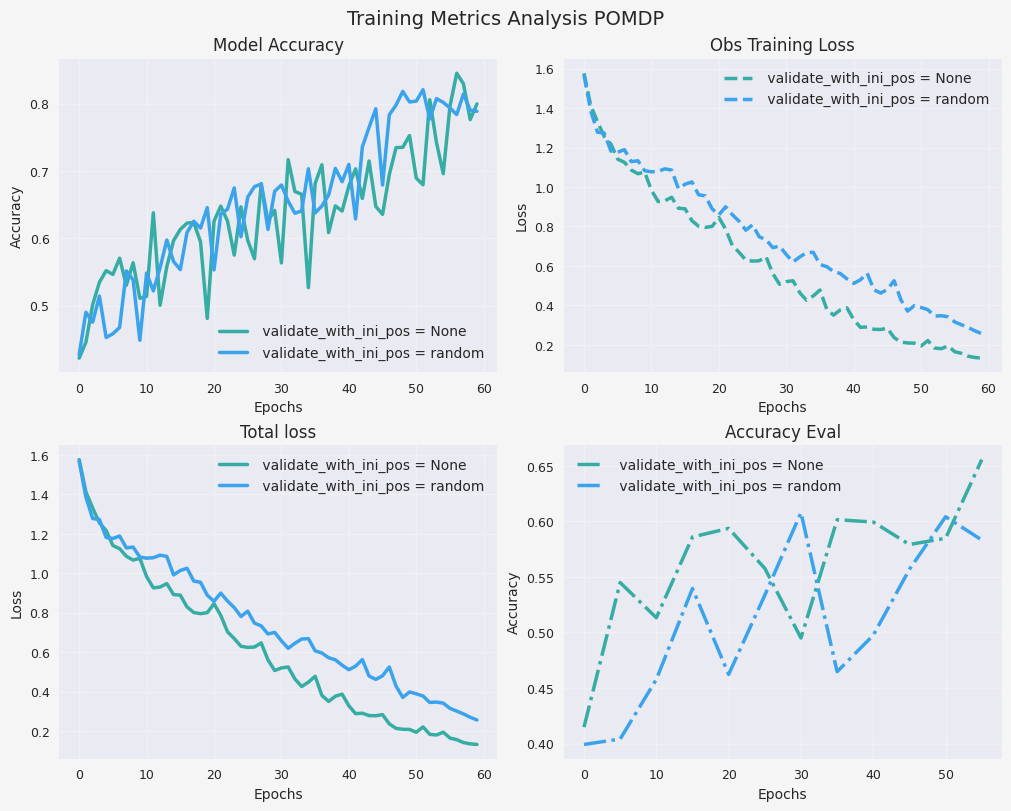

In [21]:
option_path = './configs/options.yaml'
options = read_config(option_path)
options['weight_decay'] = WEIGHT_DECAY
options['decay_step_size'] = DECAY_STEP_SIZE
options['decay_rate'] = DECAY_RATE
options['lambda_z'] = LAMBDA_Z
options['lambda_z_init'] = LAMBDA_Z_INIT
options['loss'] = "CE"
setup_path = './gridworld/config/free.yaml'
setup = read_config(setup_path)
if "start_position" in setup:
    ini_pos = setup.pop("start_position")
else:
    ini_pos = (None, None)
options['setup'] = setup
options['ini_pos'] = ini_pos
train_params = {
    #'latent_size': [64, 128, 256, 512],
    # 'learning_rate': [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    # 'inf_iters': [5, 10, 15],
    # 'inf_lr': [0.0005, 0.001, 0.005]
    #'use_preloaded': [True]
    # 'ini_pos': [(4, 0), (4, 2), (3, 1), (3, 3)]
    'validate_with_ini_pos': [None, random_pair_generator()]
}
trainer = train_with_params(options=options, train_params=train_params, modes=["pomdp"])

In [20]:
setup_path = './gridworld/config/free.yaml'
setup = read_config(setup_path)
if "start_position" in setup:
    ini_pos = setup.pop("start_position")
else:
    ini_pos = (None, None)
ini_pos = next(random_pair_generator())
print("Ini_pos: ", ini_pos)
vs, obs, init_actv = trainer.traj_gen.generate_traj_data(ini_pos=ini_pos, save=False)
print("Init_pos", trainer.traj_gen.decode_trajectory(init_actv[:, np.newaxis, :])[0])
preds_xs, _ = trainer.predict(vs, init_actv)
print("Decoded truth: ", trainer.traj_gen.decode_trajectory(obs)[0].reshape(-1, ))
print("Decoded preds: ", trainer.traj_gen.decode_trajectory(preds_xs)[0].reshape(-1, ))
print((trainer.traj_gen.decode_trajectory(obs)[0].reshape(-1, ) == trainer.traj_gen.decode_trajectory(preds_xs)[0].reshape(-1, )).mean())

Ini_pos:  (3, 3)
Init_pos [[1]]
Decoded truth:  [ 0 -1  1  0  1  0  0 -1  0  1  0  0 -1  3  1  1  1  0 -1 -1  1  0  1  1
  1  0  1  3 -1  1  3 -1  1 -1  3  1 -1 -1  0  2 -2  3 -1  1  0  1  0  2
  0 -2  2  3 -1 -1  2  3  1 -1  0  1 -1 -1  3 -1  2 -2  3  2  1  1  1 -2
  2  0  1 -1 -1  0  2  1  1  0  1  0  1 -1  3  1  0 -2  1  3  0 -1  0  2
  3 -1  0 -1]
Decoded preds:  [-1 -1  3  1  3  1  0 -1  0 -1  1  1  1  0  1  3  1 -1 -1 -2  3  0  0 -1
  2  1  1  3 -1  1  3 -1  1  1  1  3 -1  1  1  1  0  1  0  1  1  3  0  3
  2 -2  1  0 -1 -1  3  0  1  0  1  1 -1  1  3  1  0  3  1  0 -1  0  1  0
  2  0  1  0 -2  1  2  2  3  0  1  3  1  3  1  1  2  3  1  2  2  1  1 -2
 -2 -2  2  3]
0.35
